# Predict Lenght of Stay (LoS) in ICU unit (regression)
#predict LoS for ca 15k stays and train on ca 45k information ICU stays
#data from https://mimic.physionet.org/gettingstarted/access/

# Data merging
#some datasets are quite big so pyspark and koalas were used initially for data merging (4 tables were used)

In [ ]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local[*]").setAppName("LoS_ICU")
sc = SparkContext(conf = conf)
import databricks.koalas as ks
ks.set_option('compute.default_index_type','distributed') #use paralell computing

In [ ]:
events = ks.read_csv('EVENTS/EVENTS.csv.gz') # read events table number of row ca. 330M

events['CHARTTIME'] = ks.to_datetime(events['CHARTTIME']) #transform date information
events['STORETIME'] = ks.to_datetime(events['STORETIME'])
events['Date'] = events['CHARTTIME'].dt.date # select only the date part


#query the events table: take the averaged test results for each day and each patient
Avg24Hours_ITEMIDPerICUStayID = ks.sql('''
    SELECT ITEMID, avg(VALUENUM), VALUEUOM, SUBJECT_ID, ICUSTAY_ID, HADM_ID, Date
    FROM {table1}
    GROUP BY ITEMID, ICUSTAY_ID, VALUEUOM, Date, HADM_ID, SUBJECT_ID
    ORDER BY SUBJECT_ID ''', table1=events)

# len(Avg24Hours_ITEMIDPerICUStayID) # ca. 60M droped ca. 6x +/-

#query the previous + current total ICU stays for each single patient
nrICU_StaysPerSUBJ_ID=ks.sql('''
    SELECT SUBJECT_ID, COUNT(DISTINCT(ICUSTAY_ID)) as Total_ICU_Stays
    FROM {table1}
    GROUP BY SUBJECT_ID
    ORDER BY SUBJECT_ID ''', table1=events)

#merge the tw queries
EventsAvgAndMerged=Avg24Hours_ITEMIDPerICUStayID.merge(nrICU_StaysPerSUBJ_ID, on='SUBJECT_ID')

#read the admissions table (demographic information)
admissions = ks.read_csv('EVENTS/admissions.csv')

#query insurance plan, diagnosis at adimission, marital_status, ethnicity, etc...
DemographicsPerSUBJ_ID=ks.sql('''
    SELECT HADM_ID, ADMISSION_TYPE, ADMISSION_LOCATION, INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY, DIAGNOSIS as DiagnosisAtAdmission
    FROM {table1} ''', table1=admissions)

#merge on the previous dataset
EventsAvgAndDemographMerged=EventsAvgAndMerged.merge(DemographicsPerSUBJ_ID, on='HADM_ID')

#read patients table
patients= ks.read_csv('EVENTS/PATIENTS.csv')

patients['DOB'] = ks.to_datetime(patients['DOB']).dt.date #transform data information and select only the date part

#query the table regarding gender and Date of Birth
DOBirthPerSUBJ_ID=ks.sql('''
    SELECT SUBJECT_ID, DOB as DateOfBirth, GENDER
    FROM {table1} ''', table1=patients)


#merge with the previous table on SUBJECT_ID
EventsAvgAndDemographMerged2=EventsAvgAndDemographMerged.merge(DOBirthPerSUBJ_ID, on='SUBJECT_ID')


#read the d_items table # information about the lables of the analysis performed on a patient
d_items= ks.read_csv('EVENTS/D_ITEMS.csv')

#query analysis labels
LabelPerITEM_ID=ks.sql('''
    SELECT ITEMID, LABEL as AnalysisType
    FROM {table1} ''', table1=d_items)

#merge with previous information
EventsAvgAndDemographMerged3=EventsAvgAndDemographMerged2.merge(LabelPerITEM_ID, on='ITEMID')


#read the icu_stays table to gather information on how long the patient stayed in ICU (our response variable to predict)
icu_stays = ks.read_csv('EVENTS/ICUSTAYS.csv')

#query the table
LoSPerICUSTAY_ID=ks.sql('''
    SELECT ICUSTAY_ID, LOS as Lenght_Stay
    FROM {table1} ''', table1=icu_stays)

#merge with previous information
data_Saved=EventsAvgAndDemographMerged3.merge(LoSPerICUSTAY_ID, on='ICUSTAY_ID')

data_Saved.to_csv('EVENTS/final', num_files=1) # save the results for further ananlysis

#sc.stop()
#ks.reset_option('compute.default_index_type')

In [2]:
data_Saved = ks.read_csv('EVENTS/final/final.csv')

In [4]:
data_Saved.columns

Index(['ITEMID', 'avg(VALUENUM)', 'VALUEUOM', 'SUBJECT_ID', 'ICUSTAY_ID',
       'HADM_ID', 'Date', 'Total_ICU_Stays', 'ADMISSION_TYPE',
       'ADMISSION_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DiagnosisAtAdmission', 'DateOfBirth',
       'GENDER', 'AnalysisType', 'Lenght_Stay'],
      dtype='object')

In [5]:
data_Saved.isna().sum()

ITEMID                         0
avg(VALUENUM)           35187052
VALUEUOM                45360401
SUBJECT_ID                     0
ICUSTAY_ID                     0
HADM_ID                        0
Date                           0
Total_ICU_Stays                0
ADMISSION_TYPE                 0
ADMISSION_LOCATION             0
INSURANCE                      0
LANGUAGE                25536623
RELIGION                  520413
MARITAL_STATUS          10038379
ETHNICITY                      0
DiagnosisAtAdmission         814
DateOfBirth                    0
GENDER                         0
AnalysisType                   0
Lenght_Stay                    0
dtype: int64

In [6]:
len(data_Saved) #60 million rows! #chart events has 330 million rows!

59319892

In [3]:
data_Saved.head(50)

,ITEMID,avg(VALUENUM),VALUEUOM,SUBJECT_ID,ICUSTAY_ID,HADM_ID,Date,Total_ICU_Stays,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DiagnosisAtAdmission,DateOfBirth,GENDER,AnalysisType,Lenght_Stay
0,85,NaN,None,148,227964,199488,2107-09-10,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Braden Moisture,15.2614
1,128,NaN,None,148,227964,199488,2107-09-21,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Code Status,15.2614
2,184,1.000000,None,148,227964,199488,2107-09-11,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Eye Opening,15.2614
3,202,NaN,None,148,227964,199488,2107-09-17,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,GI#1 Tube PlaceCheck,15.2614
4,207,NaN,None,148,227964,199488,2107-09-18,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,GU Catheter Size,15.2614
5,478,NaN,None,148,227964,199488,2107-09-21,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Oral Cavity,15.2614
6,617,NaN,None,148,227964,199488,2107-09-16,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Respiratory Pattern,15.2614
7,640,NaN,None,148,227964,199488,2107-09-21,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Significant Events,15.2614
8,677,35.879634,Deg. C,148,227964,199488,2107-09-22,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Temperature C (calc),15.2614
9,779,144.000000,mmHg,148,227964,199488,2107-09-08,1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,THROMBOCYTOPENIA;ANEMIA,2029-07-11,F,Arterial PaO2,15.2614


In [5]:
analysis=data_Saved.AnalysisType.unique()

In [7]:
len(analysis) #6200 analysis types aka kind of 6000 columns!

6196

In [26]:
data_Saved=data_Saved.rename(columns={"avg(VALUENUM)": "DailyAverage"})  

In [35]:
#SELECT ONLY information for the first day in ICU
#we want to predict LoS at nearly the begining of patient admission in ICU...
#MIN(DATE) allows only information of the first day of information
DataPerICU_Stay_First24h = ks.sql('''SELECT MIN(Date), avg(DailyAverage), SUBJECT_ID, ICUSTAY_ID,
                                     HADM_ID, first(Total_ICU_Stays), first(ADMISSION_TYPE), first(ADMISSION_LOCATION), 
                                     first(INSURANCE), first(LANGUAGE), first(RELIGION),
                                     first(MARITAL_STATUS), first(ETHNICITY), first(DiagnosisAtAdmission), first(DateOfBirth), 
                                     first(GENDER), AnalysisType, first(Lenght_Stay)
                                     FROM {table1}
                                     GROUP BY ICUSTAY_ID, SUBJECT_ID, HADM_ID, AnalysisType''', table1=data_Saved)


In [36]:
len(DataPerICU_Stay_First24h) # 14 million rows! 

14051986

In [37]:
len(DataPerICU_Stay_First24h.SUBJECT_ID.unique()) #46 000 patients

46438

In [12]:
len(DataPerICU_Stay_First24h.ICUSTAY_ID.unique()) #61 000 icu admissions #  alot with more than 1 admission ca. 20k

60840

In [34]:
len(DataPerICU_Stay_First24h[DataPerICU_Stay_First24h['first(Total_ICU_Stays)'] > 1])

22961

In [39]:
DataPerICU_Stay_First24h.head() 

,min(Date),avg(DailyAverage),SUBJECT_ID,ICUSTAY_ID,HADM_ID,first(Total_ICU_Stays),first(ADMISSION_TYPE),first(ADMISSION_LOCATION),first(INSURANCE),first(LANGUAGE),first(RELIGION),first(MARITAL_STATUS),first(ETHNICITY),first(DiagnosisAtAdmission),first(DateOfBirth),first(GENDER),AnalysisType,first(Lenght_Stay)
0,2181-11-26,NaN,55973,200001,152234,14,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,MUSLIM,SINGLE,ASIAN - ASIAN INDIAN,CELLULITIS,2120-10-31,F,BiPap Mode,3.0786
1,2181-11-26,98.666667,55973,200001,152234,14,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,MUSLIM,SINGLE,ASIAN - ASIAN INDIAN,CELLULITIS,2120-10-31,F,Chloride (serum),3.0786
2,2181-11-25,NaN,55973,200001,152234,14,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,MUSLIM,SINGLE,ASIAN - ASIAN INDIAN,CELLULITIS,2120-10-31,F,Spontaneous Movement,3.0786
3,2199-08-07,NaN,27513,200003,163557,1,EMERGENCY,PHYS REFERRAL/NORMAL DELI,Private,PTUN,PROTESTANT QUAKER,MARRIED,WHITE,S/P RESECTION,2151-04-17,M,Risk for Falls,5.8884
4,2199-08-03,4.570000,27513,200003,163557,1,EMERGENCY,PHYS REFERRAL/NORMAL DELI,Private,PTUN,PROTESTANT QUAKER,MARRIED,WHITE,S/P RESECTION,2151-04-17,M,Total Bili (0-1.5),5.8884


In [42]:
# convert DOB to data first
DataPerICU_Stay_First24h['first(DateOfBirth)']=ks.to_datetime(DataPerICU_Stay_First24h['first(DateOfBirth)']).dt.date
#calculate age of patient at admission (just using years...)
DataPerICU_Stay_First24h['Age']=DataPerICU_Stay_First24h['min(Date)'].dt.year - DataPerICU_Stay_First24h['first(DateOfBirth)'].dt.year

c:\spark\python\pyspark\sql\pandas\functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [44]:
DataPerICU_Stay_First24h['Age'].describe() #people older than 89 are stated as 300 years old at admission due to claimed ethics issues

count    1.405199e+07
mean     6.893595e+01
std      5.360414e+01
min      0.000000e+00
25%      5.000000e+01
50%      6.400000e+01
75%      7.700000e+01
max      3.110000e+02
Name: Age, dtype: float64

In [48]:
#dataset holders provided the median information for the 89 and older population
DataPerICU_Stay_First24h['Age'].loc[DataPerICU_Stay_First24h['Age']  > 89] = 91.4 #replace with the median age

In [49]:
DataPerICU_Stay_First24h['Age'].describe() #OK

count    1.405199e+07
mean     6.000129e+01
std      2.287624e+01
min      0.000000e+00
25%      5.000000e+01
50%      6.400000e+01
75%      7.700000e+01
max      9.140000e+01
Name: Age, dtype: float64

In [59]:
DataPerICU_Stay_First24h['AnalysisType']= DataPerICU_Stay_First24h['AnalysisType'].str.lower() #all to lower case
DataPerICU_Stay_First24h['AnalysisType'] = DataPerICU_Stay_First24h['AnalysisType'].str.replace(" ","_") #replace space for '_'

In [62]:
DataPerICU_Stay_First24h['avg(DailyAverage)'].describe()

count    6.124011e+06
mean     6.934117e+01
std      2.020131e+03
min     -6.000000e+02
25%      1.919080e+00
50%      1.200000e+01
75%      6.900000e+01
max      4.154509e+06
Name: avg(DailyAverage), dtype: float64

In [ ]:

#pivot the table to have information about anaylsis results per ICUSTAY_ID
PivotTable= DataPerICU_Stay_First24h.pivot(index='ICUSTAY_ID', columns='AnalysisType', values='avg(DailyAverage)')
PivotTable=PivotTable.reset_index()

# we wont need this information: Analysis and dau«ily average has been pivoted
PivotTable=PivotTable.drop(['AnalysisType', 'avg(DailyAverage)', 'min(Date)', 'first(DateOfBirth)'])
PivotTable=PivotTable.drop_duplicates()


#save for further analysis
DataPerICU_Stay_First24h.to_csv('EVENTS/DataPerICU_Stay_First24h_2', num_files=1)
PivotTable.to_csv('EVENTS/pivot_2', num_files=1)

In [ ]:
#sc.stop()

# Use Pandas once file sizes are now much smaller

In [4]:
import pandas as pd

In [44]:
PivotTable = pd.read_csv('EVENTS/pivot_2/pivot_2.csv')

In [13]:
PivotTable.isna().sum()

#1_chest_tube_irrig.                   60840
%_inspir._time                         60840
%cool_mist                             60839
(l)_fem_art                            60840
(r)_fem_art                            60840
(r)_femoral_sheath                     60839
(r)_nephrostomy                        60840
.45%ns                                 60840
02_analyzed                            60839
02_tubing_present                      60840
1-10_ml_20%_mucomyst                   60840
1._nausea_and_vomit.                   60839
1.nausea_&vomitting                    60839
10%_alcohol/_cc/hr                     60839
10%_alcohol_cc/hr                      60839
10%_etoh_cc/hr                         60839
10%alcohl                              60839
10_min                                 60840
14_g_infiltration_scale                60840
14_g_phlebitis_scale                   60840
14_gauge_dressing_occlusive            60411
14_gauge_placed_in_outside_facility    60420
14_gauge_p

In [7]:
PivotTable.shape

(60840, 2395)

In [50]:
PivotTable.isna().sum()

14_gauge_dressing_occlusive            61364
14_gauge_placed_in_outside_facility    61373
14_gauge_placed_in_the_field           61584
16_gauge_dressing_occlusive            57193
16_gauge_placed_in_outside_facility    57242
16_gauge_placed_in_the_field           58977
18_gauge_dressing_occlusive            48478
18_gauge_placed_in_outside_facility    48574
18_gauge_placed_in_the_field           53661
20_gauge_dressing_occlusive            46054
20_gauge_placed_in_outside_facility    46150
20_gauge_placed_in_the_field           52258
22_gauge_dressing_occlusive            56835
22_gauge_placed_in_outside_facility    56901
22_gauge_placed_in_the_field           58773
3%_ns                                  61794
aado2                                  60554
aado2apacheiivalue                     61788
abd_girth                              61793
abdominal_changes:_observation         61657
abdominal_girth                        61769
abdominal_girth_(cm)                   58249
abg_chloir

In [45]:
PivotTable=PivotTable.dropna(axis=1, thresh=2) # keep columns that have at least 2 non-NANs

In [6]:
PivotTable.head()

,ICUSTAY_ID,14_gauge_dressing_occlusive,14_gauge_placed_in_outside_facility,14_gauge_placed_in_the_field,16_gauge_dressing_occlusive,16_gauge_placed_in_outside_facility,16_gauge_placed_in_the_field,18_gauge_dressing_occlusive,18_gauge_placed_in_outside_facility,18_gauge_placed_in_the_field,...,xigris_mcg/kg/hr,xigris_mg/hr,xygris,yawning,zzo2av,zzo2avi,zzz_stim_thresh_ma_[value],zzzgth___calc___(cm),zzzt_stim_thresh_ma_[value],zzzzth_in_centimeter
0,200166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
PivotTable.shape

(60840, 1583)

In [46]:
ICU_Stay_Info = pd.read_csv('EVENTS/DataPerICU_Stay_First24h_2/24h_2.csv')

In [11]:
ICU_Stay_Info.shape

(61796, 15)

In [9]:
ICU_Stay_Info.head()

,SUBJECT_ID,ICUSTAY_ID,HADM_ID,first(Total_ICU_Stays),first(ADMISSION_TYPE),first(ADMISSION_LOCATION),first(INSURANCE),first(LANGUAGE),first(RELIGION),first(MARITAL_STATUS),first(ETHNICITY),first(DiagnosisAtAdmission),first(GENDER),first(Lenght_Stay),Age
0,491,235261,157083,1,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,NaN,JEWISH,MARRIED,WHITE,CHEST PAIN;RULE-OUT MYOCARDIAL INFARCTION,M,1.7485,80.0
1,507,264188,136251,2,ELECTIVE,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,37.1612,77.0
2,518,232791,153168,9,EMERGENCY,EMERGENCY ROOM ADMIT,Private,ENGL,OTHER,MARRIED,BLACK/AFRICAN,CONGESTIVE HEART FAILURE,M,1.9691,47.0
3,975,299931,165225,6,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,ENGL,NOT SPECIFIED,SINGLE,WHITE,GASTROINTESTINAL BLEED,M,2.7093,65.0
4,1162,278191,100147,1,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NaN,CATHOLIC,MARRIED,WHITE,BRAIN MASS,M,1.4569,53.0


In [47]:
#merge with addition information on the the first 24h previously saved
PivotTable=PivotTable.merge(ICU_Stay_Info, left_on=PivotTable['ICUSTAY_ID'], right_on= ICU_Stay_Info['ICUSTAY_ID'])

In [19]:
PivotTable.head()

,14_gauge_dressing_occlusive,14_gauge_placed_in_outside_facility,14_gauge_placed_in_the_field,16_gauge_dressing_occlusive,16_gauge_placed_in_outside_facility,16_gauge_placed_in_the_field,18_gauge_dressing_occlusive,18_gauge_placed_in_outside_facility,18_gauge_placed_in_the_field,20_gauge_dressing_occlusive,...,first(ADMISSION_LOCATION),first(INSURANCE),first(LANGUAGE),first(RELIGION),first(MARITAL_STATUS),first(ETHNICITY),first(DiagnosisAtAdmission),first(GENDER),first(Lenght_Stay),Age
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EMERGENCY ROOM ADMIT,Self Pay,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,LEFT MCA ANEURYSM-SUBARACHNOID HEMORRHAGE,M,17.6084,24.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,JEWISH,MARRIED,WHITE,CORONARY ARTERY DISEASE,M,2.2313,71.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,CLINIC REFERRAL/PREMATURE,Private,ENGL,CATHOLIC,WIDOWED,WHITE,PLEURAL EFFUSION,F,4.4144,48.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CLINIC REFERRAL/PREMATURE,Private,NaN,NOT SPECIFIED,MARRIED,WHITE,ANEURYSM,M,5.0752,66.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EMERGENCY ROOM ADMIT,Medicare,ENGL,PROTESTANT QUAKER,DIVORCED,WHITE,IPH,M,0.9802,77.0


In [48]:
#drop non-relevant columns
PivotTable=PivotTable.drop(['key_0', 'ICUSTAY_ID_x', 'ICUSTAY_ID_y', 'HADM_ID', 'SUBJECT_ID'], axis=1)

In [14]:
PivotTable.shape # king of 1600 features!!

(61796, 1595)

In [20]:
PivotTable.isna().sum(axis=1)

0        1467
1        1494
2        1477
3        1519
4        1515
5        1434
6        1495
7        1443
8        1490
9        1415
10       1430
11       1521
12       1439
13       1478
14       1442
15       1437
16       1487
17       1479
18       1492
19       1470
20       1482
21       1517
22       1508
23       1431
24       1512
25       1445
26       1454
27       1507
28       1417
29       1540
         ... 
61766    1470
61767    1518
61768    1437
61769    1548
61770    1460
61771    1441
61772    1556
61773    1475
61774    1525
61775    1537
61776    1478
61777    1530
61778    1439
61779    1557
61780    1561
61781    1513
61782    1480
61783    1567
61784    1562
61785    1518
61786    1528
61787    1564
61788    1562
61789    1552
61790    1567
61791    1572
61792    1584
61793    1570
61794    1563
61795    1584
Length: 61796, dtype: int64

In [22]:
# replace special charcters on columns names that might mess with modeling
PivotTable.columns = PivotTable.columns.str.replace('[.,%,#,@,&,[,],/,-]', '') 

In [49]:
PivotTable.columns

Index(['14_gauge_dressing_occlusive', '14_gauge_placed_in_outside_facility',
       '14_gauge_placed_in_the_field', '16_gauge_dressing_occlusive',
       '16_gauge_placed_in_outside_facility', '16_gauge_placed_in_the_field',
       '18_gauge_dressing_occlusive', '18_gauge_placed_in_outside_facility',
       '18_gauge_placed_in_the_field', '20_gauge_dressing_occlusive',
       ...
       'first(ADMISSION_LOCATION)', 'first(INSURANCE)', 'first(LANGUAGE)',
       'first(RELIGION)', 'first(MARITAL_STATUS)', 'first(ETHNICITY)',
       'first(DiagnosisAtAdmission)', 'first(GENDER)', 'first(Lenght_Stay)',
       'Age'],
      dtype='object', length=1594)

# LightGBM Model

In [51]:
#split in train and test sets
from sklearn.model_selection import train_test_split
LoS, LoS_test = train_test_split(PivotTable, test_size=0.30, random_state=42) # 30% for test

In [39]:
LoS.dtypes

14_gauge_dressing_occlusive            float64
14_gauge_placed_in_outside_facility    float64
14_gauge_placed_in_the_field           float64
16_gauge_dressing_occlusive            float64
16_gauge_placed_in_outside_facility    float64
16_gauge_placed_in_the_field           float64
18_gauge_dressing_occlusive            float64
18_gauge_placed_in_outside_facility    float64
18_gauge_placed_in_the_field           float64
20_gauge_dressing_occlusive            float64
20_gauge_placed_in_outside_facility    float64
20_gauge_placed_in_the_field           float64
22_gauge_dressing_occlusive            float64
22_gauge_placed_in_outside_facility    float64
22_gauge_placed_in_the_field           float64
3_ns                                   float64
aado2                                  float64
aado2apacheiivalue                     float64
abd_girth                              float64
abdominal_changes:_observation         float64
abdominal_girth                        float64
abdominal_gir

In [53]:
LoS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43257 entries, 5647 to 56422
Columns: 1594 entries, 14_gauge_dressing_occlusive to Age
dtypes: category(9), float64(1584), int64(1)
memory usage: 524.2 MB


In [52]:
#transform object variables into category type for LGBM
for c in LoS.columns:
    col_type = LoS[c].dtypes
    if (col_type == object):
        LoS[c] = LoS[c].astype('category')
        
for c in LoS_test.columns:
    col_type = LoS_test[c].dtypes
    if (col_type == object):
        LoS_test[c] = LoS_test[c].astype('category')

C:\Users\lucia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\lucia\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [165]:
# spli feature and response variables for train and test sets
y_train=LoS['first(Lenght_Stay)']
X_train=LoS.drop('first(Lenght_Stay)', axis=1 )
y_test=LoS_test['first(Lenght_Stay)']
X_test=LoS_test.drop('first(Lenght_Stay)', axis=1 )

In [166]:
#transform object variables into categgory type for LGBM
for c in X_train.columns:
    col_type = X_train[c].dtype
    if col_type == 'object':
        X_train[c] = X_train[c].astype('category')

for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object':
        X_test[c] = X_test[c].astype('category')

In [167]:
#it requires further repalcement of special charcters on columns names that might mess with LGBM
X_train.columns = X_train.columns.str.replace('(', '').str.replace(')', '').str.replace('<', '').str.replace('#', '').str.replace('%', '').str.replace('[', '').str.replace(']', '').str.replace('-', '').str.replace('/', '').str.replace('>', '').str.replace('.', '')
X_test.columns = X_test.columns.str.replace('(', '').str.replace(')', '').str.replace('<', '').str.replace('#', '').str.replace('%', '').str.replace('[', '').str.replace(']', '').str.replace('-', '').str.replace('/', '').str.replace('>', '').str.replace('.', '')

In [168]:
import re  # transform from json to not cause problems in lightbgm due to special json characters in column names
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [132]:
#according to dataset manager some analysis may contain misspelling and not uniform information about analysis but it is a open
# free character introduction describing the analysis performed
# string match was performed in order to merge columns that most probably refer to the same analysis type
import difflib
matches=dict()

for c in X_train.columns:
    matches[c]= difflib.get_close_matches(c, X_train.columns, cutoff = 0.70, n = 15)
    

In [134]:
matches['22_gauge_placed_in_outside_facility']

['22_gauge_placed_in_outside_facility',
 '20_gauge_placed_in_outside_facility',
 '18_gauge_placed_in_outside_facility',
 '16_gauge_placed_in_outside_facility',
 '14_gauge_placed_in_outside_facility',
 'iabp_placed_in_outside_facility',
 'cco_pac_placed_in_outside_facility',
 'ric_placed_in_outside_facility',
 'icp_line_placed_in_outside_facility',
 'ava_line_placed_in_outside_facility',
 'sheath_placed_in_outside_facility',
 'trauma_line_placed_in_outside_facility',
 'picc_line_placed_in_outside_facility',
 'midline_placed_in_outside_facility',
 'pa_catheter_placed_in_outside_facility']

In [1]:
#replace values for the mean in the most similar analysis type # this will replace a lot of NaN

for similars in matches.values():
    average1=X_train[similars].mean(axis=1)
    average2=X_test[similars].mean(axis=1)
    X_train[similars]= X_train[similars].T.fillna(average1).T
    X_test[similars]= X_test[similars].T.fillna(average2).T


In [170]:
X_train.head()

,14_gauge_dressing_occlusive,14_gauge_placed_in_outside_facility,14_gauge_placed_in_the_field,16_gauge_dressing_occlusive,16_gauge_placed_in_outside_facility,16_gauge_placed_in_the_field,18_gauge_dressing_occlusive,18_gauge_placed_in_outside_facility,18_gauge_placed_in_the_field,20_gauge_dressing_occlusive,...,firstADMISSION_TYPE,firstADMISSION_LOCATION,firstINSURANCE,firstLANGUAGE,firstRELIGION,firstMARITAL_STATUS,firstETHNICITY,firstDiagnosisAtAdmission,firstGENDER,Age
5647,1.0,0.0,0.000000,1.0,0.0,0.000000,1.0,0.0,0.000000,1.0,...,EMERGENCY,CLINIC REFERRAL/PREMATURE,Medicare,ENGL,PROTESTANT QUAKER,WIDOWED,WHITE,SEPSIS,F,61.0
49026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Private,NaN,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,INCREASED FLUID AT GRAFT SITE,F,58.0
6112,1.0,1.0,0.833333,1.0,1.0,0.833333,1.0,1.0,0.833333,1.0,...,EMERGENCY,CLINIC REFERRAL/PREMATURE,Private,ENGL,UNOBTAINABLE,WIDOWED,UNKNOWN/NOT SPECIFIED,S/P CARDIAC ARREST,F,91.4
45879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EMERGENCY,EMERGENCY ROOM ADMIT,Private,NaN,OTHER,DIVORCED,WHITE,ASTHMA,F,33.0
60640,1.0,0.0,0.000000,1.0,0.0,0.000000,1.0,0.0,0.000000,1.0,...,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Government,ENGL,MUSLIM,MARRIED,UNKNOWN/NOT SPECIFIED,CHEST PAIN\CARDIAC CATH,M,45.0


In [172]:
X_train.shape

(43257, 1593)

In [181]:
#drop duplicated columns

X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [182]:
X_train.shape

(43257, 1560)

In [20]:
import lightgbm as lgb #pip install lightgbm

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=-1,
                               metric= 'l2', subsample = 0.8 , force_col_wise = True,
                              learning_rate= 0.1, colsample_bytree= 0.2, reg_alpha= 3, reg_lambda= 1,
                              n_estimators=5000, max_depth=-1, num_leaves=100 )

In [183]:
#fit the lghbm model
clf.fit(X_train, y_train, early_stopping_rounds= 30, eval_metric= 'l2', #mean squared error
                            eval_set= [(X_test,y_test)], eval_names= ['test'], verbose= 100, feature_name= 'auto', categorical_feature= 'auto')

C:\Users\lucia\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\lucia\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 30 rounds
[100]	test's l2: 8.2747
[200]	test's l2: 7.72796
[300]	test's l2: 7.56052
[400]	test's l2: 7.50668
[500]	test's l2: 7.4783
[600]	test's l2: 7.45319
[700]	test's l2: 7.44262
[800]	test's l2: 7.43858
[900]	test's l2: 7.43164
[1000]	test's l2: 7.42564
[1100]	test's l2: 7.42306
[1200]	test's l2: 7.42138
Early stopping, best iteration is:
[1265]	test's l2: 7.41953


LGBMRegressor(colsample_bytree=0.2, force_col_wise=True, metric='l2',
              n_estimators=5000, num_leaves=100, objective='regression',
              reg_alpha=3, reg_lambda=1, subsample=0.8)

In [184]:
#predict LoS for test
LoS_hat=clf.predict(X_test) #LoS is in days

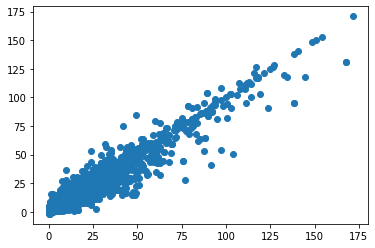

In [186]:
from matplotlib import pyplot as plt
plt.scatter(y_test, LoS_hat) # not bad! it is quite a linear diagonal centered line as expected

In [190]:
y_test.median()

2.0881

In [197]:
clf_2 = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=-1,
                               metric= 'l2_root', subsample = 0.8 , force_col_wise = True,
                              learning_rate= 0.01, colsample_bytree= 0.2, reg_alpha= 3, reg_lambda= 1,
                              n_estimators=20000, max_depth=-1, num_leaves=100 )

#fit the lghbm model
clf_2.fit(X_train, y_train, early_stopping_rounds= 30, eval_metric= 'l2_root', #root mean squared error
                            eval_set= [(X_test,y_test)], eval_names= ['test'], verbose= 1000, feature_name= 'auto', categorical_feature= 'auto')

Training until validation scores don't improve for 30 rounds
[1000]	test's rmse: 2.79971
[2000]	test's rmse: 2.68856
[3000]	test's rmse: 2.6562
[4000]	test's rmse: 2.642
[5000]	test's rmse: 2.63493
[6000]	test's rmse: 2.63045
[7000]	test's rmse: 2.6272
[8000]	test's rmse: 2.62522
[9000]	test's rmse: 2.62397
[10000]	test's rmse: 2.62304
Early stopping, best iteration is:
[10005]	test's rmse: 2.62304


LGBMRegressor(colsample_bytree=0.2, force_col_wise=True, learning_rate=0.01,
              metric='l2_root', n_estimators=20000, num_leaves=100,
              objective='regression', reg_alpha=3, reg_lambda=1, subsample=0.8)

In [195]:
y_test.mean() #5.18, average error on prediction with a 2.63 rmse gives ca. 50% error on predicton on average!

5.187222050811799

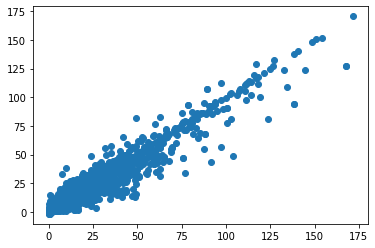

In [198]:
LoS_hat_2=clf_2.predict(X_test_2) #LoS is in days
plt.scatter(y_test, LoS_hat_2) # better it could be improved maybe with hyperopr hyperparameter optimization

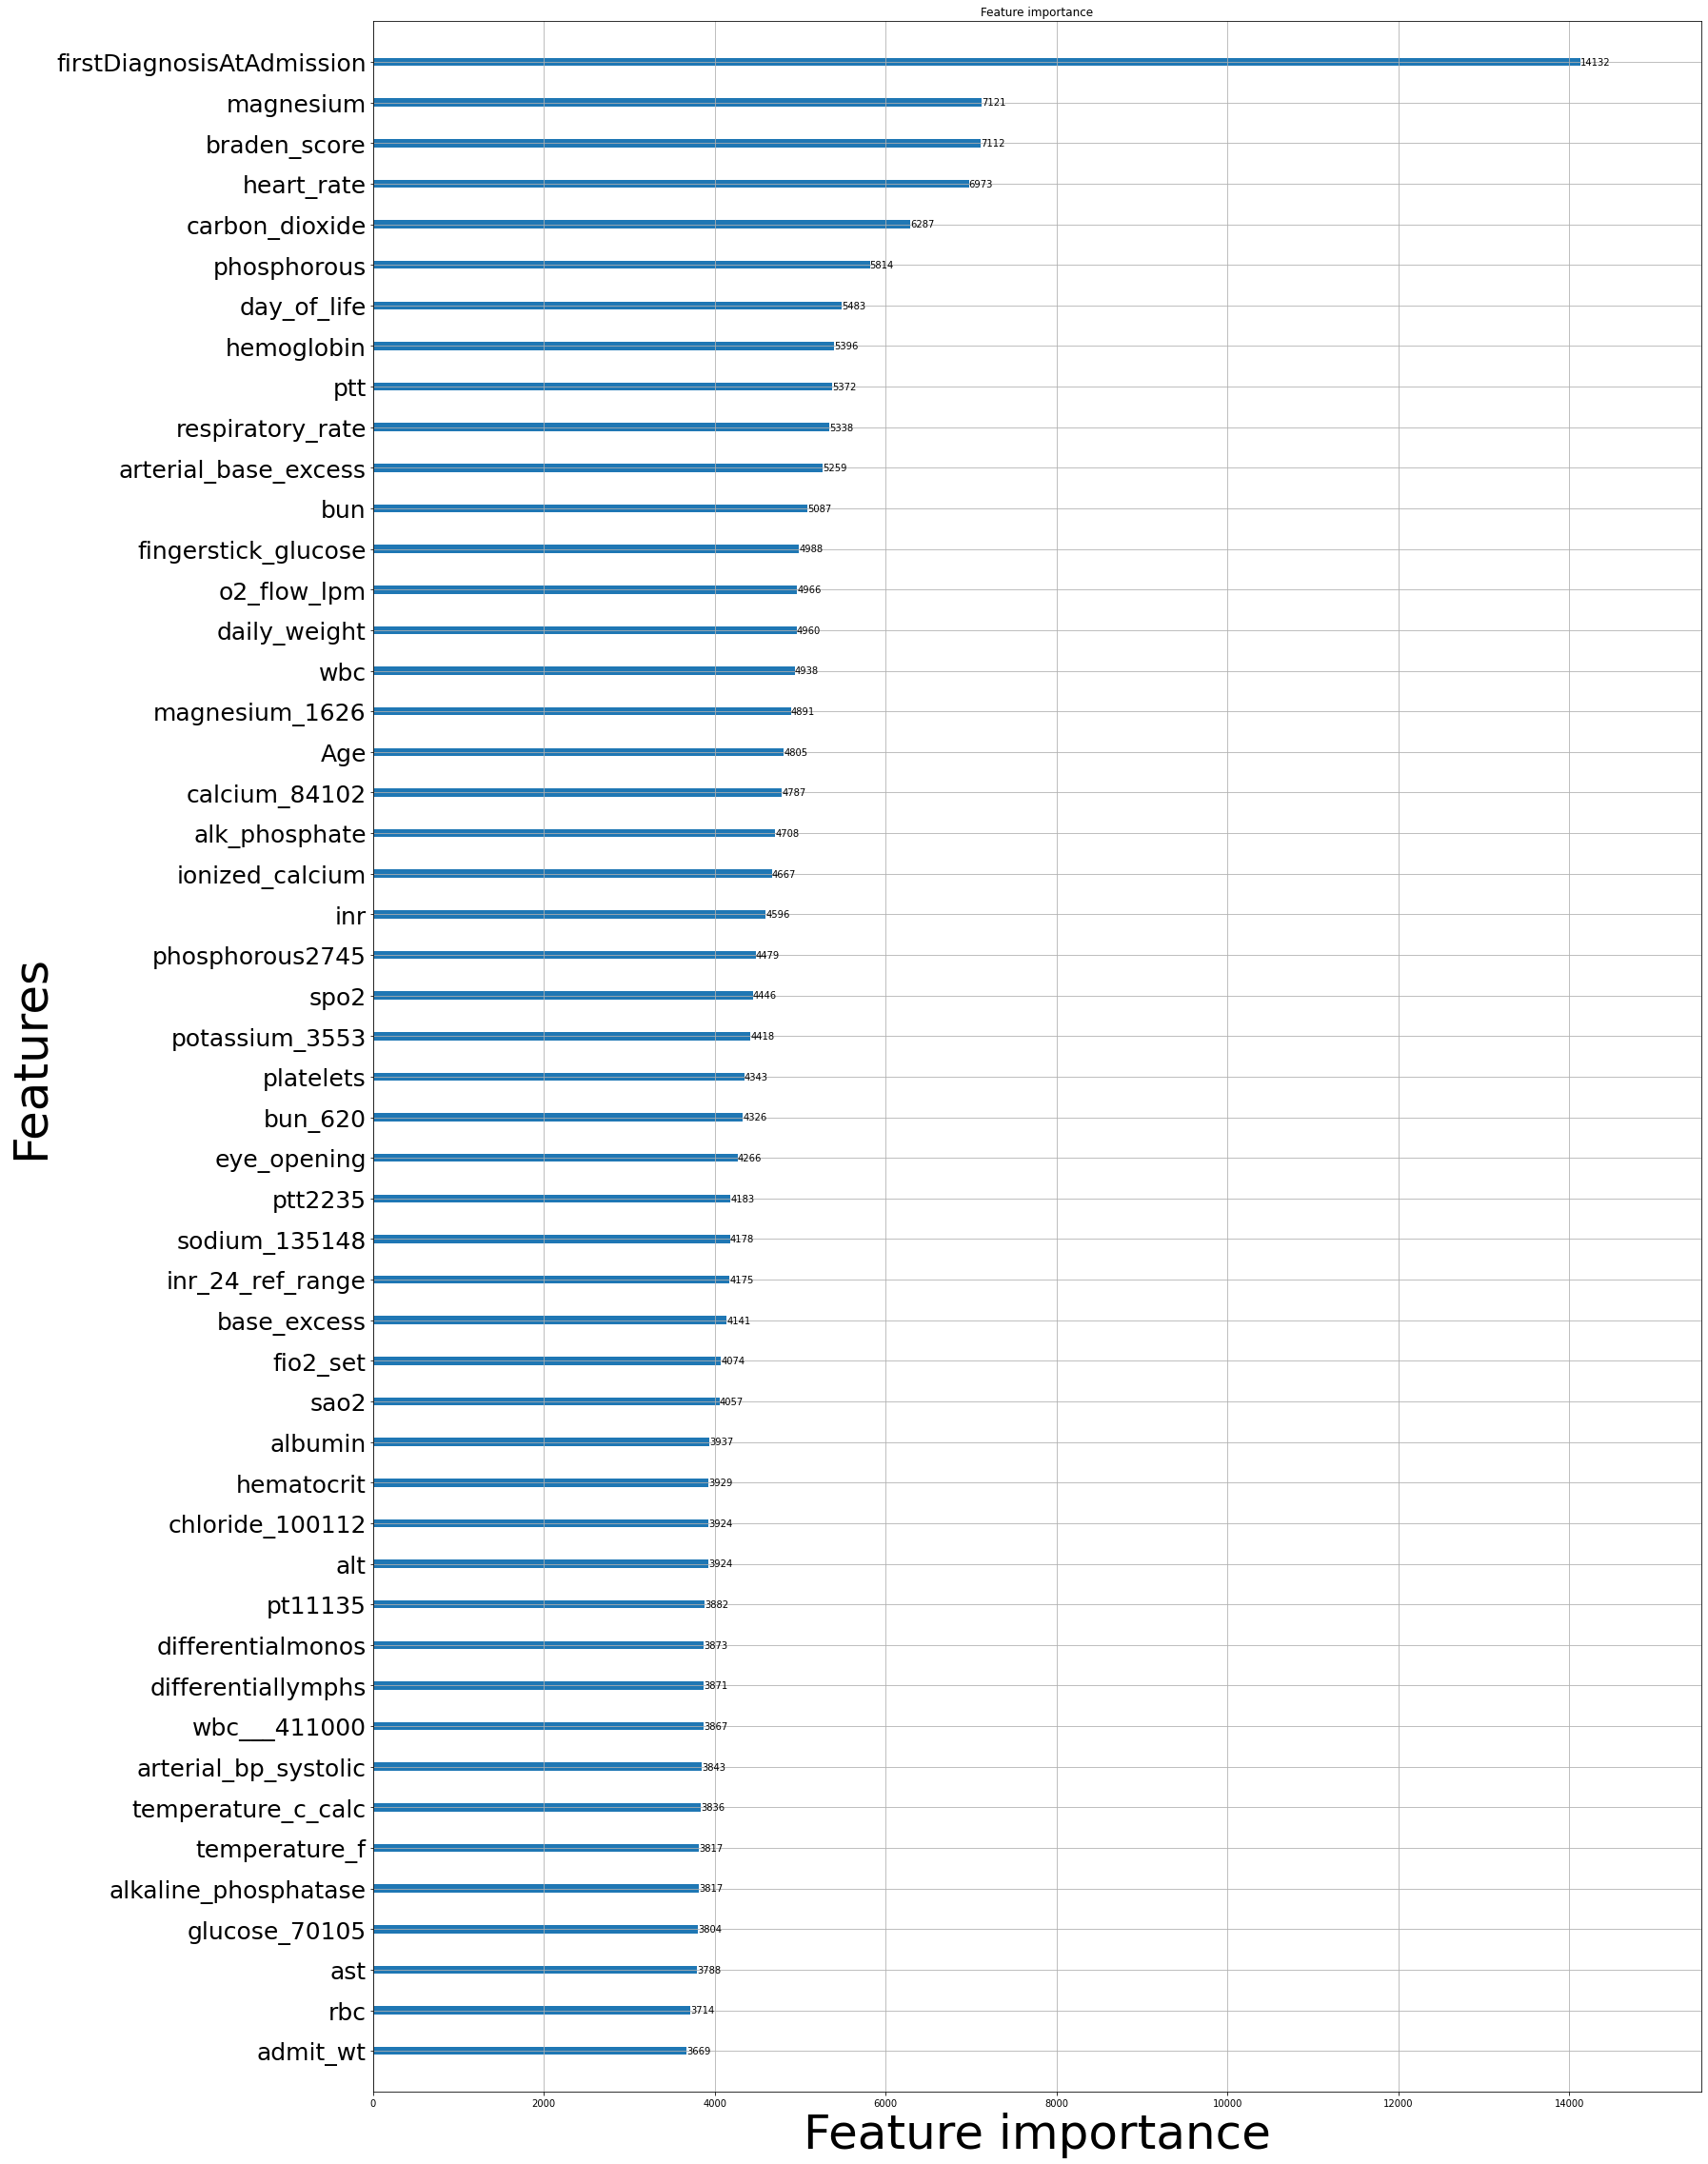

In [206]:
plt.rcParams['ytick.labelsize'] = 25
lgb.plot_importance(clf_2, max_num_features=50, figsize = (25,40)) 
plt.show()
# most relevant feature is diagnosis at admitance
#although diagnosis at admitance might contain some error, 
#if some one is admitted to ICU they must be much strongely sure about the problem of the patient!!